In [1]:
import pandas as pd
import seaborn as sns
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols 
from scipy import signal
from datetime import datetime, timedelta

import numpy as np

from bokeh.models import ColumnDataSource, RangeTool, BoxAnnotation, Label, Column, YearsTicker
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, curdoc

In [24]:
effr = pd.read_csv('effr.csv')
print(len(effr))
effr.tail(n = 40)

830


,DATE,EFFR
790,2020-05-01,0.05
791,2020-06-01,0.08
792,2020-07-01,0.09
793,2020-08-01,0.10
794,2020-09-01,0.09
795,2020-10-01,0.09
796,2020-11-01,0.09
797,2020-12-01,0.09
798,2021-01-01,0.09
799,2021-02-01,0.08


In [3]:
unrate = pd.read_csv('unrate.csv')
print(len(unrate))
unrate.head()

908


,DATE,UNEMPLOYMENT
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5


In [22]:
pce = pd.read_csv('pce.csv')
print(len(pce))
pce.tail(n = 20)

257


,DATE,PCE
237,2018-07-01,1.4
238,2018-10-01,1.9
239,2019-01-01,1.5
240,2019-04-01,2.1
241,2019-07-01,1.6
242,2019-10-01,1.2
243,2020-01-01,1.9
244,2020-04-01,-1.0
245,2020-07-01,3.2
246,2020-10-01,1.5


In [5]:
merged = effr.merge(unrate, on='DATE')
merged = merged.merge(pce, on='DATE')

unrate_col = merged.pop('UNEMPLOYMENT')
effr_col = merged.pop('EFFR')

merged['UNEMPLOYMENT'] = unrate_col
merged['EFFR'] = effr_col

#merged.dropna(inplace=True)
print(len(merged))
merged.head()

257


,DATE,PCE,UNEMPLOYMENT,EFFR
0,1959-04-01,2.1,5.2,2.96
1,1959-07-01,2.7,5.1,3.47
2,1959-10-01,2.3,5.7,3.98
3,1960-01-01,1.3,5.2,3.99
4,1960-04-01,1.5,5.2,3.92


In [6]:
merged = merged[merged['DATE'] >= '2000-01-01']
merged.head(n = 10)

,DATE,PCE,UNEMPLOYMENT,EFFR
163,2000-01-01,2.1,4.0,5.45
164,2000-04-01,1.4,3.8,6.02
165,2000-07-01,1.9,4.0,6.54
166,2000-10-01,2.0,3.9,6.51
167,2001-01-01,2.6,4.2,5.98
168,2001-04-01,1.5,4.4,4.80
169,2001-07-01,1.0,4.6,3.77
170,2001-10-01,1.9,5.3,2.49
171,2002-01-01,1.2,5.7,1.73
172,2002-04-01,2.2,5.9,1.75


In [7]:
merged.tail()

,DATE,PCE,UNEMPLOYMENT,EFFR
252,2022-04-01,4.7,3.6,0.33
253,2022-07-01,4.7,3.5,1.68
254,2022-10-01,4.4,3.7,3.08
255,2023-01-01,4.9,3.4,4.33
256,2023-04-01,3.7,3.4,4.83


In [8]:
merged['EFFR_LAG_12M'] = merged['EFFR'].shift(4)

merged['UNEMPLOYMENT_LAG_12M'] = merged['UNEMPLOYMENT'].shift(4)
merged['UNEMPLOYMENT_LAG_24M'] = merged['UNEMPLOYMENT'].shift(8)

merged['PCE_LAG_6M'] = merged['PCE'].shift(2)
merged['PCE_LAG_12M'] = merged['PCE'].shift(4)
merged['PCE_LAG_24M'] = merged['PCE'].shift(8)

merged.head()

,DATE,PCE,UNEMPLOYMENT,EFFR,EFFR_LAG_12M,UNEMPLOYMENT_LAG_12M,UNEMPLOYMENT_LAG_24M,PCE_LAG_6M,PCE_LAG_12M,PCE_LAG_24M
163,2000-01-01,2.1,4.0,5.45,NaN,NaN,NaN,NaN,NaN,NaN
164,2000-04-01,1.4,3.8,6.02,NaN,NaN,NaN,NaN,NaN,NaN
165,2000-07-01,1.9,4.0,6.54,NaN,NaN,NaN,2.1,NaN,NaN
166,2000-10-01,2.0,3.9,6.51,NaN,NaN,NaN,1.4,NaN,NaN
167,2001-01-01,2.6,4.2,5.98,5.45,4.0,NaN,1.9,2.1,NaN


                            OLS Regression Results                            
Dep. Variable:            PCE_LAG_12M   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     11.89
Date:                Mon, 18 Sep 2023   Prob (F-statistic):           0.000868
Time:                        21:50:39   Log-Likelihood:                -125.24
No. Observations:                  90   AIC:                             254.5
Df Residuals:                      88   BIC:                             259.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6149      0.139     11.591      0.0

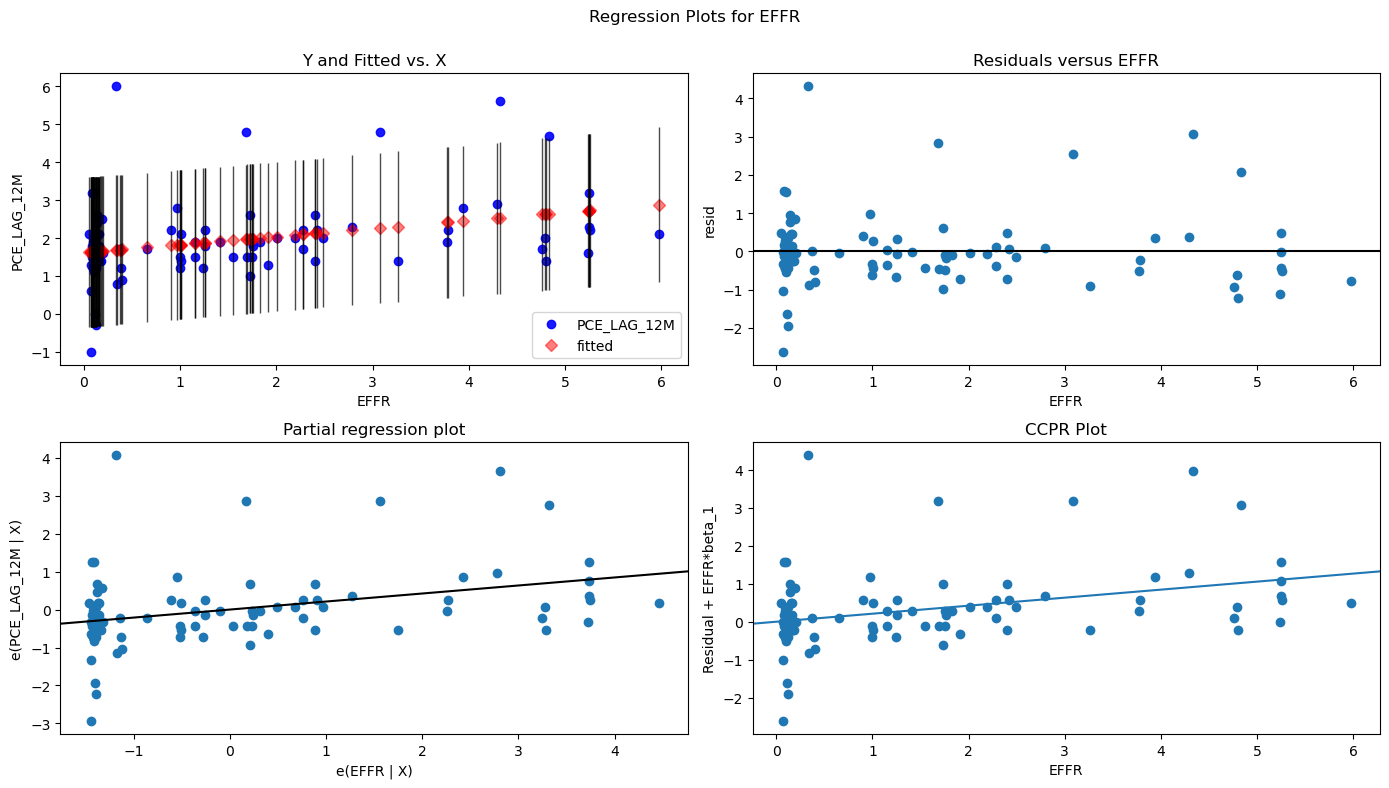

In [12]:
# fit simple linear regression model
mod = ols('PCE_LAG_12M ~ EFFR',
                   data=merged).fit()
  
# display model summary
print(mod.summary())
  
# modify figure size
fig = plt.figure(figsize=(14, 8))
  
# creating regression plots
fig = sm.graphics.plot_regress_exog(mod,
                                    'EFFR',
                                    fig=fig)

                            OLS Regression Results                            
Dep. Variable:           UNEMPLOYMENT   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     40.98
Date:                Mon, 18 Sep 2023   Prob (F-statistic):           6.37e-09
Time:                        21:50:45   Log-Likelihood:                -183.72
No. Observations:                  94   AIC:                             371.4
Df Residuals:                      92   BIC:                             376.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.8751      0.240     28.678      0.0

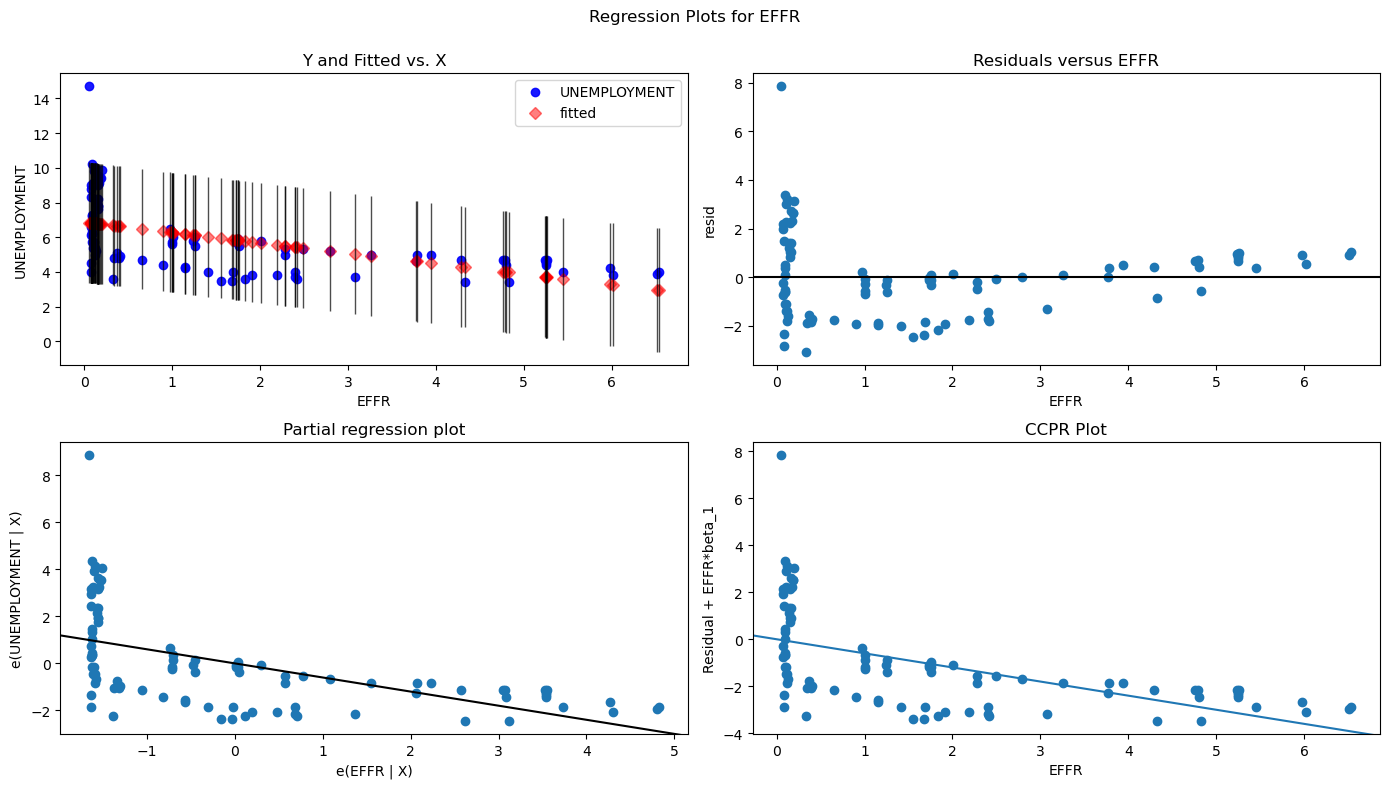

In [13]:
# fit simple linear regression model
mod = ols('UNEMPLOYMENT ~ EFFR',
                   data=merged).fit()
  
# display model summary
print(mod.summary())
  
# modify figure size
fig = plt.figure(figsize=(14, 8))
  
# creating regression plots
fig = sm.graphics.plot_regress_exog(mod,
                                    'EFFR',
                                    fig=fig)

In [14]:
# merged2 = pd.melt(merged, id_vars=['DATE'], var_name=['SIGNAL'], value_name='VALUE', ignore_index = False)
# merged2.sort_values(by=['DATE'], inplace=True)
# merged2.reset_index(drop=True, inplace=True)
# print(len(merged2))
# merged2.tail(n=10)

In [ ]:
import numpy as np
from scipy import signal
rng = np.random.default_rng()
x = rng.standard_normal(1000)
y = np.concatenate([rng.standard_normal(100), x])
correlation = signal.correlate(x, y, mode="full")
lags = signal.correlation_lags(x.size, y.size, mode="full")
lag = lags[np.argmax(correlation)]
lag

In [ ]:
def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')
    return c
    
ccf_effr_cpi = ccf_values(merged['EFFR'], merged['INFLATION'])

In [ ]:
lags = signal.correlation_lags(len(merged['EFFR']), len(merged['INFLATION']))
def ccf_plot(lags, ccf):
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf)
    ax.axhline(-2/np.sqrt(23), color='red', label='5% confidence interval')
    ax.axhline(2/np.sqrt(23), color='red')
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(ccf), color = 'blue', lw = 1, 
    linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'blue', lw = 1, 
    linestyle='--')
    ax.set(ylim = [-1, 1])
    ax.set_title('Cross Correation EFFR and INFLATION', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', 
    fontsize = 12)
    ax.set_xlabel('Time Lags', weight='bold', fontsize = 12)
    plt.legend()
    
ccf_plot(lags, ccf_effr_cpi)

In [15]:
output_notebook()
curdoc().theme = 'dark_minimal'

TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select"

dates = np.array(merged['DATE'], dtype=np.datetime64)
range_mid_date = int(len(dates) / 2) + 1
range_end_date = dates[len(dates) - 1]


Loading BokehJS ...

In [16]:
# For instance, the average CPI inflation rate was 3.56 percent from 1948 to 1978, and 3.74 percent 
# from 1979 (when the Fed first had a formal price stability mandate) to 2013. And from 2021 to 2023
# it has been above the mandate.

In [30]:
effr_src = ColumnDataSource(data=dict(date=dates, rate=merged['EFFR']))

unemp_no_lag_src = ColumnDataSource(data=dict(date=dates, rate=merged['UNEMPLOYMENT']))
unemp_lag_src = ColumnDataSource(data=dict(date=dates, rate=merged['UNEMPLOYMENT_LAG_24M']))

unemp_src = unemp_no_lag_src

p = figure(title='EFFR, Unemployment', height=300, width=800, tools=TOOLS, #toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           x_range=(dates[0], range_end_date))

p.line('date', 'rate', source=effr_src, color='#56B4E9', legend_label='Effective Federal Funds Rate')
p.line('date', 'rate', source=unemp_no_lag_src, color='#E69F00', legend_label='Unemployment Rate')
p.yaxis.axis_label = 'Rate'

#p.line('date', 'rate', source=effr_chg_src, color='#3195ce', legend_label='EFFR % (1-month change)')
#p.line('date', 'rate', source=cpi_src, color='#E69F00', legend_label='Inflation (12-month % change)')
#p.line('date', 'rate', source=unemp_lag_src, color='#009E73', legend_label='Lagged Unemployment (12 Months)')
# p.line('date', 'rate', source=unemp_src, color='#009E73', legend_label='Unemployment')

# range_tool = RangeTool(x_range=p.x_range)
# range_tool.overlay.fill_color = "white"
# range_tool.overlay.fill_alpha = 0.3
# select = figure(title="Drag the middle and edges of the selection box to change the range above",
#                 height=130, width=800, y_range=p.y_range,
#                 x_axis_type="datetime", y_axis_type=None,
#                 toolbar_location=None)

# select.line('date', 'rate', source=effr_src, color='#56B4E9')
# select.line('date', 'rate', source=unemp_no_lag_src, color='#E69F00')
# #select.ygrid.grid_line_color = None
# select.add_tools(range_tool)
#show(Column(p, select))

show(Column(p))

In [29]:
effr_src = ColumnDataSource(data=dict(date=dates, rate=merged['EFFR']))
pce_src = ColumnDataSource(data=dict(date=dates, rate=merged['PCE']))

p = figure(title='EFFR, PCE', height=300, width=800, tools=TOOLS, #toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           x_range=(dates[0], range_end_date))

p.line('date', 'rate', source=effr_src, color='#56B4E9', legend_label='Effective Federal Funds Rate')
p.line('date', 'rate', source=pce_src, color='#009E73', legend_label='PCE')
p.yaxis.axis_label = 'Rate'

# range_tool = RangeTool(x_range=p.x_range)
# range_tool.overlay.fill_color = "white"
# range_tool.overlay.fill_alpha = 0.2

# select = figure(title="Drag the middle and edges of the selection box to change the range above",
#                 height=400, width=800, y_range=p.y_range,
#                 x_axis_type="datetime")

# select.line('date', 'rate', source=effr_src, color='#56B4E9')
# select.line('date', 'rate', source=pce_src, color='#E69F00')
# #select.ygrid.grid_line_color = None
# select.add_tools(range_tool)


show(Column(p))

In [28]:
effr_src = ColumnDataSource(data=dict(date=dates, rate=merged['EFFR']))
pce_src = ColumnDataSource(data=dict(date=dates, rate=merged['PCE_LAG_12M']))

p = figure(title='EFFR, Lagged PCE (12 Month)', height=300, width=800, tools=TOOLS, #toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           x_range=(dates[0], range_end_date))

p.line('date', 'rate', source=effr_src, color='#56B4E9', legend_label='Effective Federal Funds Rate')
p.line('date', 'rate', source=pce_src, color='#009E73', legend_label='Lagged PCE (12 Month)')
p.yaxis.axis_label = 'Rate'

# range_tool = RangeTool(x_range=p.x_range)
# range_tool.overlay.fill_color = "white"
# range_tool.overlay.fill_alpha = 0.2

# select = figure(title="Drag the middle and edges of the selection box to change the range above",
#                 height=400, width=800, y_range=p.y_range,
#                 x_axis_type="datetime")

# select.line('date', 'rate', source=effr_src, color='#56B4E9')
# select.line('date', 'rate', source=pce_src, color='#E69F00')
# #select.ygrid.grid_line_color = None
# select.add_tools(range_tool)


show(Column(p))

In [27]:
effr_src = ColumnDataSource(data=dict(date=dates, rate=merged['EFFR']))
pce_src = ColumnDataSource(data=dict(date=dates, rate=merged['PCE_LAG_12M']))

p = figure(title='EFFR, Unemployment, Lagged PCE (12 Month)', height=300, width=800, tools=TOOLS, #toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           x_range=(dates[0], range_end_date))

p.line('date', 'rate', source=effr_src, color='#56B4E9', legend_label='Effective Federal Funds Rate')
p.line('date', 'rate', source=pce_src, color='#009E73', legend_label='Lagged PCE (12 Month)')
p.line('date', 'rate', source=unemp_src, color='#E69F00', legend_label='Unemployment')
p.yaxis.axis_label = 'Rate'

# range_tool = RangeTool(x_range=p.x_range)
# range_tool.overlay.fill_color = "white"
# range_tool.overlay.fill_alpha = 0.2

# select = figure(title="Drag the middle and edges of the selection box to change the range above",
#                 height=400, width=800, y_range=p.y_range,
#                 x_axis_type="datetime")

# select.line('date', 'rate', source=effr_src, color='#56B4E9')
# select.line('date', 'rate', source=pce_src, color='#E69F00')
# #select.ygrid.grid_line_color = None
# select.add_tools(range_tool)


show(Column(p))

In [25]:
# import numpy as np

# from bokeh.layouts import column
# from bokeh.models import ColumnDataSource, RangeTool, Span, BoxAnnotation, Label
# from bokeh.plotting import figure
# from bokeh.io import output_notebook, show

# output_notebook()

In [19]:
unemp_src = ColumnDataSource(data=dict(date=dates, rate=merged['UNEMPLOYMENT']))

p = figure(title='Unemployment measured against 4% Fed target', height=300, width=800, tools=TOOLS, #toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           x_range=(dates[0], range_end_date))

p.line('date', 'rate', source=unemp_src, color='#E69F00', legend_label='Unemployment')
p.yaxis.axis_label = 'Rate'

#p.hspan(y=[merged['UNEMPLOYMENT'].mean()],line_width=[1], line_color="#E69F00", line_dash='dashed')
p.hspan(y=[4.0],line_width=[1], line_color="red")

black_swan_events = [
    ('9/11', pd.to_datetime('2001-09-11'), 15),
    ('SARS', pd.to_datetime('2003-01-14'), 40),
    ('Global Financial Crisis', pd.to_datetime('2007-10-09'), 1022),
    ('Libya Intervention', pd.to_datetime('2011-02-18'), 29),
    ('Brexit', pd.to_datetime('2016-06-08'), 9),
    ('COVID-19', pd.to_datetime('2019-02-19'), 1500)
    ]
for bse in black_swan_events:
    box = BoxAnnotation(left=bse[1], right=bse[1] + timedelta(days=bse[2]), fill_alpha=0.2, fill_color='pink')
    label = Label(x=bse[1], y=0, x_units='data', y_units='screen', text=bse[0],
              border_line_color=None, text_font_size='10px',text_color='white',
              background_fill_color=None, background_fill_alpha=1.0)    
    p.add_layout(box)
    p.add_layout(label)
    
# range_tool = RangeTool(x_range=p.x_range)
# range_tool.overlay.fill_color = "white"
# range_tool.overlay.fill_alpha = 0.2

# select = figure(title="Drag the middle and edges of the selection box to change the range above",
#                 height=130, width=800, y_range=p.y_range,
#                 x_axis_type="datetime", y_axis_type=None)


# select.line('date', 'rate', source=unemp_src, color='#E69F00')
# select.ygrid.grid_line_color = None
# select.add_tools(range_tool)


show(Column(p))

In [ ]:
merged['UNEMPLOYMENT'].mean()

In [ ]:
merged['EFFR'].corr(merged['INFLATION'])


In [ ]:
merged['EFFR'].corr(merged['UNEMPLOYMENT'])

In [ ]:
ccf_effr_cpi = ccf_values(merged['EFFR'], merged['INFLATION'])

In [ ]:
lags = signal.correlation_lags(len(merged['EFFR']), len(merged['INFLATION']))

def ccf_plot(lags, ccf):
    fig, ax =plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf)
    ax.axhline(-2/np.sqrt(23), color='red', label='5% confidence interval')
    ax.axhline(2/np.sqrt(23), color='red')
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(ccf), color = 'blue', lw = 1, linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'blue', lw = 1, linestyle='--')
    ax.set(ylim = [-1, 1])
    ax.set_title('Cross Correation EFFR and INFLATION', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', fontsize = 12)
    ax.set_xlabel('Time Lags (Months)', weight='bold', fontsize = 12)
    plt.legend()
    
ccf_plot(lags, ccf_effr_cpi)